In [9]:
#Imports 

#utilities
import os
import time
import joblib

#stat tools
import numpy as np
from scipy.stats import ttest_1samp
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from hyppo.ksample import Hotelling

#regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


#cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.random_projection import GaussianRandomProjection


#graphing
import matplotlib.pyplot as plt



In [2]:
#don't need to change these

#for concat of x and z 
def interleave(x, z, seed=None):
    """ Interleave x and z dimension-wise.
    Args:
        x (n_samples, x_dim) array.
        z (n_samples, z_dim) array.
    Returns
        An array of shape (n_samples, x_dim + z_dim) in which
            the columns of x and z are interleaved at random.
    """
    state = np.random.get_state()
    np.random.seed(seed or int(time.time()))
    total_ids = np.random.permutation(x.shape[1]+z.shape[1])
    np.random.set_state(state)
    out = np.zeros([x.shape[0], x.shape[1] + z.shape[1]])
    out[:, total_ids[:x.shape[1]]] = x
    out[:, total_ids[x.shape[1]:]] = z
    return out

#computes MSE
def obtain_error(data_and_i):
    """ 
    A function used for multithreaded computation of the fcit test statistic.
    data['x']: First variable.
    data['y']: Second variable.
    data['z']: Conditioning variable.
    data['data_permutation']: Permuted indices of the data.
    data['perm_ids']: Permutation for the bootstrap.
    data['n_test']: Number of test points.
    data['clf']: Decision tree regressor.
    """
    data, i = data_and_i
    x = data['x']
    y = data['y']
    z = data['z']
    if data['reshuffle']:
        perm_ids = np.random.permutation(x.shape[0])
    else:
        perm_ids = np.arange(x.shape[0])
    data_permutation = data['data_permutation'][i]
    n_test = data['n_test']
    clf = data['clf']

    x_z = interleave(x[perm_ids], z, seed=i)

    clf.fit(x_z[data_permutation][n_test:], y[data_permutation][n_test:])
    return mse(y[data_permutation][:n_test],
        clf.predict(x_z[data_permutation][:n_test]))


In [3]:
def cross_val(x, y, z, cv_grid, verbose, model, prop_test):
    """ Choose the best decision tree hyperparameters by
    cross-validation. The hyperparameter to optimize is min_samples_split
    (see sklearn's DecisionTreeRegressor).
    Args:
        x (n_samples, x_dim): Input data array.
        y (n_samples, y_dim): Output data array.
        z (n_samples, z_dim): Optional auxiliary input data.
        cv_grid (list): List of hyperparameter values to try in CV.
        regresor (sklearn classifier): Which regression model to use.
        prop_test (float): Proportion of validation data to use.
    Returns:
        DecisionTreeRegressor with the best hyperparameter setting.
    """
    
    splitter = ShuffleSplit(n_splits=3, test_size=prop_test)
    cv = GridSearchCV(estimator=model, cv=splitter,
            param_grid=cv_grid, n_jobs=-1)
    cv.fit(interleave(x, z), y)
    
    return type(model)(**cv.best_params_)
    

In [4]:
def test(x, y, z, model, cv_grid, ksamp_test=None, num_perm=8, prop_test=.1,
    discrete=(False, False), plot_return=False, verbose=False, **kwargs):
    """ Fast conditional independence test, based on decision-tree regression.
    See Chalupka, Perona, Eberhardt 2017 [arXiv link coming].
    Args:
        x (n_samples, x_dim): First variable.
        y (n_samples, y_dim): Second variable.
        z (n_samples, z_dim): Conditioning variable. If z==None (default),
            then performs an unconditional independence test.
        num_perm: Number of data permutations to estimate
            the p-value from marginal stats.
        prop_test (int): Proportion of data to evaluate test stat on.
        discrete (bool, bool): Whether x or y are discrete.
        plot_return (bool): If True, return statistics useful for plotting.
        verbose (bool): Print out progress messages (or not).
        cv_grid (list): cv params
    Returns:
        p (float): The p-value for the null hypothesis
            that x is independent of y.
    """
    ###################################################
    # Compute test set size.
    n_samples = x.shape[0]
    n_test = int(n_samples * prop_test)

    if z is None:
        z = np.empty([n_samples, 0])

    if discrete[0] and not discrete[1]:
        # If x xor y is discrete, use the continuous variable as input.
        x, y = y, x
    elif x.shape[1] < y.shape[1]:
        # Otherwise, predict the variable with fewer dimensions.
        x, y = y, x
        
    # Normalize y to make the decision tree stopping criterion meaningful.
    y = StandardScaler().fit_transform(y)
    
    # Set up storage for true data and permuted data MSEs.
    d0_stats = np.zeros(num_perm)
    d1_stats = np.zeros(num_perm)
    data_permutations = [np.random.permutation(n_samples) for i in range(num_perm)]
    
    ########################################################
    # Compute mses for y = f(x, z), varying train-test splits.
    clf = cross_val(x, y, z, cv_grid, verbose, model, prop_test=prop_test)
    datadict = {
            'x': x,
            'y': y,
            'z': z,
            'data_permutation': data_permutations,
            'n_test': n_test,
            'reshuffle': False,
            'clf': clf,
            }
    d1_stats = np.array(joblib.Parallel(n_jobs=-1, max_nbytes=100e6)(
        joblib.delayed(obtain_error)((datadict, i)) for i in range(num_perm)))

    
    #####################################################################33
    # Compute mses for y = f(x, reshuffle(z)), varying train-test splits.
    if z.shape[1] == 0:
        x_indep_y = x[np.random.permutation(n_samples)]
    else:
        x_indep_y = np.empty([x.shape[0], 0])
        
        
    clf = cross_val(x_indep_y, y, z, cv_grid, verbose, model, prop_test=prop_test)
    
    datadict['reshuffle'] = True
    datadict['x'] = x_indep_y
    d0_stats = np.array(joblib.Parallel(n_jobs=-1, max_nbytes=100e6)(
        joblib.delayed(obtain_error)((datadict, i)) for i in range(num_perm)))

    
    
    if verbose:
        np.set_printoptions(precision=3)
        print('D0 statistics: {}'.format(d0_stats))
        print('D1 statistics: {}\n'.format(d1_stats))

        
    #######################################################33    
    # Compute the p-value (one-tailed t-test
    # that mean of mse ratios equals 1) <- default, o.w. use k-sample.
    
    
    if not ksamp_test:
        t, p_value = ttest_1samp(d0_stats / d1_stats, 1)
        if t < 0:
            p_value = 1 - p_value / 2
        else:
            p_value = p_value / 2

        if plot_return:
            return (p_value, d0_stats, d1_stats)
        else:
            return p_value
    else:
        _, p_value = ksamp_test.test(d0_stats, d1_stats)
        
        return p_value[0]

In [5]:
#Using random forest
x = np.random.rand(1000, 1)
y = np.random.randn(1000, 1)

pval_i = test(x, y, z=None, model=DecisionTreeRegressor(), cv_grid={'min_samples_split': [2, 8, 64, 512, 1e-2, .2, .4]
                                                           }) # p-value should be uniform on [0, 1].
pval_d = test(x, x + y, z=None, model=DecisionTreeRegressor(), cv_grid={'min_samples_split': [2, 8, 64, 512, 1e-2, .2, .4]
                                                               }) # p-value should be very small.


print("pval_i: ", pval_i)
print("pval_d: ", pval_d) # as expected 

pval_i:  0.1414177027380779
pval_d:  0.027107766030217275


In [7]:
#Using linear regression

x = np.random.rand(1000, 1)
y = np.random.randn(1000, 1)

pval_i = test(x, y, z=None,model=LinearRegression(), cv_grid={'fit_intercept': [True, False]
                                                           }) # p-value should be uniform on [0, 1].
pval_d = test(x, x + y, z=None,model=LinearRegression(), cv_grid={'fit_intercept': [True, False]
                                                               }) # p-value should be very small.


print("pval_i: ", pval_i)
print("pval_d: ", pval_d) # as expected 

pval_i:  0.48207157125288336
pval_d:  0.0021442234617511415


In [9]:
#Using random forest
x = np.random.rand(1000, 1)
y = np.random.randn(1000, 1)


#k = Hotelling()
k = None

pval_i = test(x, y, z=None, model=DecisionTreeRegressor(), ksamp_test=k, 
              cv_grid={'min_samples_split': [2, 8, 64, 512, 1e-2, .2, .4]}) 


pval_d = test(x, x + y, z=None, model=DecisionTreeRegressor(), ksamp_test=k,
              cv_grid={'min_samples_split': [2, 8, 64, 512, 1e-2, .2, .4]})


print("pval_i: ", pval_i)
print("pval_d: ", pval_d) 

pval_i:  0.18448198186211112
pval_d:  0.0015768555702319305


## Experiments

Text(0.5, 1.0, 'dependent')

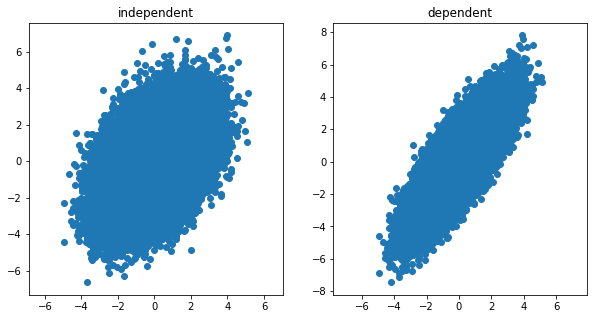

In [21]:
dim = 1
n = 100000
np.random.seed(12)
'''
z -> sample n x d from multivariate gaussian
'''

#independent

z1 = np.random.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim), size = (n))



'''
A -> dim x dim 
'''

A1 = np.random.normal(loc = 0, scale = 1, size = dim*dim).reshape(dim,dim)
B1 = np.random.normal(loc = 0, scale = 1, size = dim*dim).reshape(dim,dim)

x1 = A1@z1.T + np.random.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim), size = (n)).T
y1 = B1@z1.T + np.random.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim), size = (n)).T

#dependent

np.random.seed(12)
z2 = np.random.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim), size = (n))

A2 = np.random.normal(loc = 0, scale = 1, size = dim*dim).reshape(dim,dim)
B2 = np.random.normal(loc = 0, scale = 1, size = dim*dim).reshape(dim,dim)

x2 = A2@z2.T + np.random.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim), size = (n)).T
y2 = B2@x2 + np.random.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim), size = (n)).T


plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.axis('equal')
plt.scatter(x1,y1)
plt.title('independent')

plt.subplot(1,2,2)
plt.axis('equal')
plt.scatter(x2,y2)
plt.title('dependent')

In [22]:
k=None


np.random.seed(122)
print(test(x1.T, y1.T, z1, model=DecisionTreeRegressor(), ksamp_test=k, 
              cv_grid={'min_samples_split': [2, 8, 64, 512, 1e-2, .2, .4]})) #ind, expect close to 1 

np.random.seed(122)
print(test(x2.T, y2.T, z2,model=DecisionTreeRegressor(), ksamp_test=k, 
              cv_grid={'min_samples_split': [2, 8, 64, 512, 1e-2, .2, .4]})) #dep, expect close to 0

0.5613924004771689
2.914475967415397e-12


In [17]:
def gen_ind_gauss(dim, n):
    
    z = np.random.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim), size = n)

    A = np.random.normal(loc = 0, scale = 1, size = dim*dim).reshape(dim,dim)
    B = np.random.normal(loc = 0, scale = 1, size = dim*dim).reshape(dim,dim)
    
    x = A.dot(z.T) + np.random.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim), size = n).T
    y = B.dot(z.T) + np.random.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim), size = n).T
    
    return x, y, z
    
    
    
def gen_dep_gauss(dim, n):
    z = np.random.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim), size = n)

    A = np.random.normal(loc = 0, scale = 1, size = dim*dim).reshape(dim,dim)
    B = np.random.normal(loc = 0, scale = 1, size = dim*dim).reshape(dim,dim)

    x = A.dot(z.T) + np.random.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim), size = n).T
    y = B.dot(x) + np.random.multivariate_normal(mean = np.zeros(dim), cov = np.eye(dim), size = n).T
    
    return x, y, z



In [13]:
dim = 1
n = 100000

x1, y1, z1 = gen_ind_gauss(dim,n)
x2, y2, z2 = gen_dep_gauss(dim,n)

k = None



pval_i = test(x1.T, y1.T, z1, model=DecisionTreeRegressor(), ksamp_test=k, 
              cv_grid={'min_samples_split': [2, 8, 64, 512, 1e-2, .2, .4]}) 

pval_d = test(x2.T, y2.T, z2, model=DecisionTreeRegressor(), ksamp_test=k, 
              cv_grid={'min_samples_split': [2, 8, 64, 512, 1e-2, .2, .4]}) 


In [14]:
print(pval_i)
print(pval_d)

0.9077376923890623
4.502629953010262e-15


In [23]:
dim = 1
k = None

model = DecisionTreeRegressor()
cv_grid = {'min_samples_split': [2, 8, 64, 512, 1e-2, .2, .4]}


for n in [1000, 100000]:
    
    np.random.seed(12)
    ind_x, ind_y, ind_z = gen_ind_gauss(dim, n)
    
    np.random.seed(12)
    dep_x, dep_y, dep_z = gen_dep_gauss(dim, n)
    
    np.random.seed(122)
    print('ind: ', test(ind_x.T, ind_y.T, ind_z, model=model, ksamp_test=k, cv_grid=cv_grid) )
    
    np.random.seed(122)
    print('dep: ', test(dep_x.T, dep_y.T, dep_z, model=model, ksamp_test=k, cv_grid=cv_grid) )

ind:  0.17530833141121233
dep:  2.0924801204521633e-06
ind:  0.5613924004771503
dep:  2.9144759674153762e-12


In [38]:
dim = 1
samps = [int(i) for i in np.arange(10e2, 10e5+1, 50000*2)]

k = None

model = DecisionTreeRegressor()
cv_grid = {'min_samples_split': [2, 8, 64, 512, 1e-2, .2, .4]}

#for dim in dims:

ind_p_vals = {}

dep_p_vals = {}

for n in samps:

    np.random.seed(12)   
    ind_x, ind_y, ind_z = gen_ind_gauss(dim, n)

    np.random.seed(12)  
    dep_x, dep_y, dep_z = gen_dep_gauss(dim, n)
    
    print('samp: ', n)

    np.random.seed(122)  
    ind_p_vals[n] = test(ind_x.T, ind_y.T, ind_z, model=model, ksamp_test=k, cv_grid=cv_grid) 
    
    print(ind_p_vals[n])
    
    np.random.seed(122)  
    dep_p_vals[n] = test(dep_x.T, dep_y.T, dep_z, model=model, ksamp_test=k, cv_grid=cv_grid) 
    
    print(dep_p_vals[n])
    
    

samp:  1000
0.1753083314110392
2.0924801204521633e-06
samp:  101000
0.5
3.599174748166735e-14
samp:  201000
0.007756824170585334
1.0789466017614715e-11
samp:  301000
0.13547122105521275
6.422793667626829e-15
samp:  401000
0.0007686502958668363
4.748551173111515e-13
samp:  501000
0.5
1.8494665892094792e-12
samp:  601000
0.5
1.4888112828009435e-10
samp:  701000
0.5
7.303762637865264e-12
samp:  801000
0.5
2.755266384285521e-09
samp:  901000
0.07022182357346586
1.4229942399728535e-14


In [39]:
t0 = [i for i in ind_p_vals.keys()]
t1 = [i for i in ind_p_vals.values()]

t2 = [i for i in dep_p_vals.keys()]
t3 = [i for i in dep_p_vals.values()]

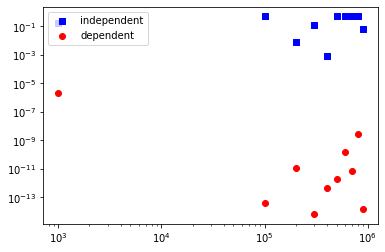

In [40]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(t0, t1, c='b', marker="s", label='independent')
ax1.scatter(t2, t3,  c='r', marker="o", label='dependent')
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.legend(loc='upper left');
plt.show()

## NOT seeded

In [15]:
dim = 1
samps = [int(i) for i in np.arange(10e2, 10e5+1, 50000*2)]

k = None

model = DecisionTreeRegressor()
cv_grid = {'min_samples_split': [2, 8, 64, 512, 1e-2, .2, .4]}

#for dim in dims:

ind_p_vals = {}

dep_p_vals = {}

for n in samps:

    ind_x, ind_y, ind_z = gen_ind_gauss(dim, n)

    dep_x, dep_y, dep_z = gen_dep_gauss(dim, n)

    ind_p_vals[n] = test(ind_x.T, ind_y.T, ind_z, model=model, ksamp_test=k, cv_grid=cv_grid) 

    dep_p_vals[n] = test(dep_x.T, dep_y.T, dep_z, model=model, ksamp_test=k, cv_grid=cv_grid) 

In [16]:
t0 = [i for i in ind_p_vals.keys()]
t1 = [i for i in ind_p_vals.values()]

t2 = [i for i in dep_p_vals.keys()]
t3 = [i for i in dep_p_vals.values()]

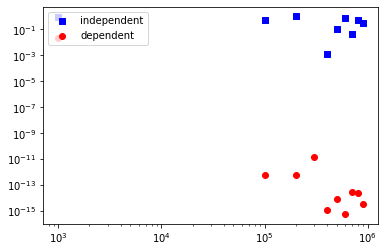

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(t0, t1, c='b', marker="s", label='independent')
ax1.scatter(t2, t3,  c='r', marker="o", label='dependent')
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.legend(loc='upper left');
plt.show()

In [19]:
dim = 1
samps = [int(i) for i in np.arange(10e2, 10e5+1, 50000*2)]

k = None

model=LinearRegression()

cv_grid={'fit_intercept': [True, False]}

#for dim in dims:
b 
ind_p_vals = {}

dep_p_vals = {}

for n in samps:

    ind_x, ind_y, ind_z = gen_ind_gauss(dim, n)

    dep_x, dep_y, dep_z = gen_dep_gauss(dim, n)

    ind_p_vals[n] = test(ind_x.T, ind_y.T, ind_z, model=model, ksamp_test=k, cv_grid=cv_grid) 

    dep_p_vals[n] = test(dep_x.T, dep_y.T, dep_z, model=model, ksamp_test=k, cv_grid=cv_grid) 

In [20]:
t0 = [i for i in ind_p_vals.keys()]
t1 = [i for i in ind_p_vals.values()]

t2 = [i for i in dep_p_vals.keys()]
t3 = [i for i in dep_p_vals.values()]

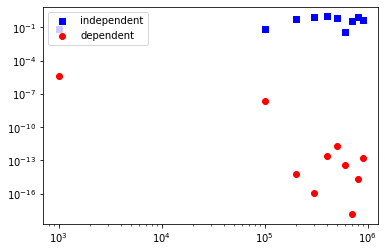

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(t0, t1, c='b', marker="s", label='independent')
ax1.scatter(t2, t3,  c='r', marker="o", label='dependent')
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.legend(loc='upper left');
plt.show()